In [2]:
import pandas as pd
import numpy as np
path = 'dataset/labelled_tweets.csv'
    
tweet = pd.read_csv(path, usecols=['text', 'polarity'])
# Remove rows will nan values
tweet = tweet.dropna()
tweet = tweet.reindex(np.random.permutation(tweet.index))
# preprocessing bit
# replace user handles (@Jumia) to be empty
pattern = "(@[A-Za-z0-9]+)|(http|https|ftp)://[a-zA-Z0-9./]+|#(\w+)"
tweet['text'] = tweet.text.str.replace(pattern, '')
tweet.head()

,polarity,text
450,positive,Awesome. Tx GS ^SG
1359,negative,"hi so I ordered something on Monday, and I ha..."
1652,neutral,Sawa
1584,neutral,Morning guys. Wanted to know the progress on ...
242,neutral,kindly I request to know the process of makin...


In [3]:
# examine class distribution
tweet.polarity.value_counts()

neutral     959
negative    748
positive    100
Name: polarity, dtype: int64

In [4]:
# convert label to a numerical count by creating a new column
tweet['polarity_num'] = tweet.polarity.map({'negative':0,'positive':1,'neutral':2})

In [5]:
# Define X matrix as features and y as vectors
X = tweet.text
y = tweet.polarity_num
print(X.shape)
print(y.shape)

(1807,)
(1807,)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1355,)
(452,)
(1355,)
(452,)


### Model evaluation

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import re
import numpy as np

In [8]:
clf_nb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
clf_nb = clf_nb.fit(X_train,y_train)

In [9]:
np.mean(y_pred_class == y_test)

0.76106194690265483

### SVM

In [40]:
clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3, n_iter=5,random_state=42))])
clf_svm = clf_svm.fit(X_train,y_train)
y_pred_class = clf_svm.predict(X_test)

C:\Users\brian\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
clf_reg = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])
clf_reg = clf_reg.fit(X_train,y_train)

### Grid Search

In [12]:
from sklearn.model_selection import GridSearchCV 
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), }

In [28]:
clf_list = [clf_nb, clf_reg, clf_svm]
clf_dict = {
    clf_nb : {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),},
    clf_reg : {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), },
    clf_svm : {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3),}
}

scores = {}
# loop every key and value in the dictionary
for clf, params in clf_dict.items():
    gs_clf = GridSearchCV(clf, params, n_jobs=-1, cv=10)
    gs_clf = gs_clf.fit(X_train, y_train)
    scores[clf] = gs_clf.best_score_



# for clf in clf_list:
#     gs_clf = GridSearchCV(clf, parameters, n_jobs=-1, cv=10)
#     gs_clf = gs_clf.fit(X_train, y_train)
#     print(gs_clf.best_score_)

In [30]:
# pickle the scores for faster access
from sklearn.externals import joblib
joblib.dump(scores, 'scores.pkl') 

['scores.pkl']

In [54]:
scores = joblib.load('scores.pkl')
maximum = max(scores, key=scores.get)  # Just use 'min' instead of 'max' for minimum.
print(maximum, scores[maximum])
# scores

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))]) 0.746863468635


In [30]:
gs_clf.best_score_

0.75350553505535056

In [31]:
gs_clf.best_params_

{'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [43]:
# calculate accuracy of class predictions
from sklearn import metrics
from sklearn.metrics import classification_report
metrics.accuracy_score(y_test, y_pred_class)
print(classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77       178
          1       1.00      0.27      0.42        30
          2       0.77      0.87      0.82       244

avg / total       0.79      0.78      0.77       452



In [33]:
vect = CountVectorizer()
X_dtm = vect.fit_transform(X)

In [41]:
from sklearn.model_selection import cross_val_score
logreg = MultinomialNB()
print(cross_val_score(logreg, X_dtm, y, cv=10, scoring='accuracy').mean())

0.744387789747


# Confusion Matrix

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[133   0  45]
 [  3   8  19]
 [ 32   0 212]]
Normalized confusion matrix
[[ 0.75  0.    0.25]
 [ 0.1   0.27  0.63]
 [ 0.13  0.    0.87]]


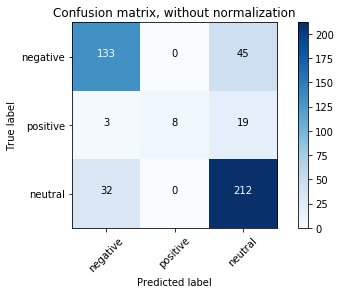

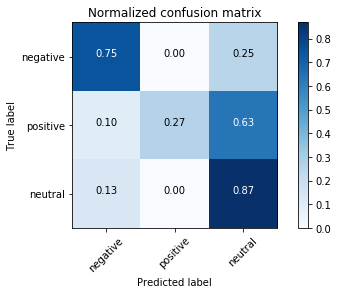

In [48]:
"""
This snippet of code was extracted from: 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = ['negative','positive','neutral']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [52]:
clf_svm.predict(['OK'])

array([2], dtype=int64)